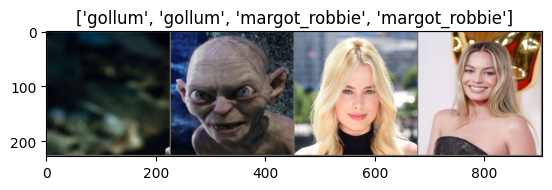

In [9]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(
                224
            ),  # ImageNet models were trained on 224x224 images
            transforms.RandomHorizontalFlip(),  # flip horizontally 50% of the time - increases train set variability
            transforms.ToTensor(),  # convert it to a PyTorch tensor
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),  # ImageNet models expect this norm
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "dataset"
# Create train and validation datasets and loaders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=0
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Helper function for displaying images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Un-normalize the images
    inp = std * inp + mean
    # Clip just in case
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [25]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, transforms

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(
                224
            ),  # ImageNet models were trained on 224x224 images
            transforms.RandomHorizontalFlip(),  # flip horizontally 50% of the time - increases train set variability
            transforms.ToTensor(),  # convert it to a PyTorch tensor
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),  # ImageNet models expect this norm
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "dataset"
# Create train and validation datasets and loaders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Helper function for displaying images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Un-normalize the images
    inp = std * inp + mean
    # Clip just in case
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()


# Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])
# training


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_time = []  # we'll keep track of the time needed for each epoch

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time


# Download a pre-trained ResNet18 model and freeze its weights
# model = torchvision.models.resnet18(pretrained=True)

model = torchvision.models.mobilenet_v3_large(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.classifier[-1].in_features 
model.classifier[-1] = nn.Linear(num_ftrs, 5) 
# Send the model to the GPU
model = model.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(model.classifier[-1].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model, epoch_time = train_model(
    model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=15
)

Epoch 1/15
----------


c:\Users\romai\Desktop\Centrale lyon\MOD et MOM\Intro apprentissage profond et IA\TD\mod_4_6-td2_cnn\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 1.4284 Acc: 0.4718
val Loss: 1.0412 Acc: 0.7170

Epoch 2/15
----------
train Loss: 1.0040 Acc: 0.7128
val Loss: 0.7002 Acc: 0.8491

Epoch 3/15
----------
train Loss: 0.8464 Acc: 0.7692
val Loss: 0.5337 Acc: 0.9057

Epoch 4/15
----------
train Loss: 0.7183 Acc: 0.8051
val Loss: 0.4630 Acc: 0.9057

Epoch 5/15
----------
train Loss: 0.6146 Acc: 0.8308
val Loss: 0.4187 Acc: 0.9057

Epoch 6/15
----------
train Loss: 0.6140 Acc: 0.7795
val Loss: 0.3913 Acc: 0.9057

Epoch 7/15
----------
train Loss: 0.5536 Acc: 0.8359
val Loss: 0.3919 Acc: 0.9057

Epoch 8/15
----------
train Loss: 0.6331 Acc: 0.7949
val Loss: 0.3928 Acc: 0.9057

Epoch 9/15
----------
train Loss: 0.5499 Acc: 0.8615
val Loss: 0.3979 Acc: 0.9057

Epoch 10/15
----------
train Loss: 0.6320 Acc: 0.8103
val Loss: 0.4132 Acc: 0.8868

Epoch 11/15
----------
train Loss: 0.5567 Acc: 0.8410
val Loss: 0.4065 Acc: 0.9057

Epoch 12/15
----------
train Loss: 0.5740 Acc: 0.8205
val Loss: 0.4105 Acc: 0.8868

Epoch 13/15
----------


In [26]:
os.makedirs("models", exist_ok=True) 

PATH_MODELE_FINAL = 'models/MobileNetV3_large_transfer_final.pth'
torch.save(model.state_dict(), PATH_MODELE_FINAL)

In [27]:
from torch.utils.mobile_optimizer import optimize_for_mobile
import torch

# Assure-toi que ton modèle est sur CPU pour l'export (GPU peut causer des problèmes d'export)
model_cpu = model.to('cpu') 
model_cpu.eval()

# Nécessite un échantillon d'entrée (Dummy Input)
dummy_input = torch.randn(1, 3, 224, 224) 

# Tracing pour obtenir le modèle au format TorchScript
traced_model = torch.jit.trace(model_cpu, dummy_input, strict=False)

PATH_TORCHSCRIPT_CPU = 'models/MobileNetV3_large_traced_cpu.pt'
traced_model.save(PATH_TORCHSCRIPT_CPU)
print(f"Modèle TorchScript CPU sauvegardé : {PATH_TORCHSCRIPT_CPU}")

# 1. Charger le modèle TorchScript
loaded_traced_model = torch.jit.load(PATH_TORCHSCRIPT_CPU)

# 2. Utiliser la fonction d'optimisation PyTorch Mobile
# Cette fonction réduit la précision de certains tenseurs (poids) en Int8 ou Int16
# et supprime les opérations non nécessaires à l'inférence mobile.

# L'option 'quantization' active la réduction de poids simple.
quantized_lite_model = optimize_for_mobile(
    loaded_traced_model, 
    backend="CPU",  # Use 'CPU' as the backend for mobile optimization
)

PATH_QUANTIZED_LITE = 'models/MobileNetV3_large_quantized_simple.pt'
quantized_lite_model._save_for_lite_interpreter(PATH_QUANTIZED_LITE)
print(f"Modèle quantifié *simple* pour ExecuTorch : {PATH_QUANTIZED_LITE}")

Modèle TorchScript CPU sauvegardé : models/MobileNetV3_large_traced_cpu.pt
Modèle quantifié *simple* pour ExecuTorch : models/MobileNetV3_large_quantized_simple.pt


In [28]:
import os

models_dir = "models"
if os.path.exists(models_dir):
    for file in os.listdir(models_dir):
        file_path = os.path.join(models_dir, file)
        if os.path.isfile(file_path):
            size_bytes = os.path.getsize(file_path)
            size_mb = size_bytes / (1024 * 1024)
            print(f"{file}: {size_mb:.2f} MB")


MobileNetV3_large_quantized_simple.pt: 16.01 MB
MobileNetV3_large_traced_cpu.pt: 16.69 MB
MobileNetV3_large_transfer_final.pth: 16.26 MB
resnet18_quantized_simple.pt: 42.62 MB
resnet18_traced_cpu.pt: 42.85 MB
resnet18_transfer_final.pth: 42.72 MB
